In [103]:
import numpy as np
import librosa
import IPython.display as ipd
import pandas as pd
import noisereduce as nr

def cyclic_shift(audio, shift):
    """Cyclically shift the audio signal by `shift` samples."""
    return np.roll(audio, shift)
def reconstruct_signal_from_windowed_frames(windowed_frames, frame_length, hop_length, original_length):
    """Reconstruct an audio signal from windowed frames."""
    # Initialize the reconstructed signal array with zeros
    reconstructed_signal = np.zeros(original_length)

    # Number of frames
    num_frames = windowed_frames.shape[1]

    for i in range(num_frames):
        start_idx = i * hop_length
        end_idx = start_idx + frame_length
        # Add the windowed frame back, taking care of boundary conditions
        reconstructed_signal[start_idx:end_idx] += windowed_frames[:, i]

    return reconstructed_signal
def apply_window(audio, event_position, frame_length, hop_length):
    """Apply windowing based on the event position and energy distribution."""
    # Example: Simple windowing, adjust according to your energy analysis
    frames = librosa.util.frame(audio, frame_length=frame_length, hop_length=hop_length)
    windowed_frames = np.hanning(frame_length).reshape(-1, 1)*frames
    return reconstruct_signal_from_windowed_frames(windowed_frames,frame_length,hop_length,len(audio))

def augment_audio(audio, start_time, end_time, sr=44100,shift=1):
    """Load audio, perform cyclic shift based on event duration, and apply windowing."""

    # Convert start and end times to samples
    start_sample = int(start_time * sr)
    end_sample = int(end_time * sr)

    # Calculate event duration in samples
    event_duration_samples = end_sample-start_sample

    # Example shift: Move the event to the middle of the audio file
    # Calculate new start position as halfway through the audio
    new_start_sample = end_sample+event_duration_samples*shift
    # Calculate shift amount
    shift_amount = new_start_sample - start_sample

    # Perform cyclic shift
    shifted_audio = cyclic_shift(audio, shift_amount)
    windowed_audio = apply_window(shifted_audio, new_start_sample, frame_length=1024,hop_length=512)

    return windowed_audio
def detect_event_positions(y, frame_length=1024, hop_length=512, energy_threshold=0.02,sr=44100):
    # Noise reduce
    y = nr.reduce_noise(y=y,sr=sr)
    # Calculate short-term energy
    energy = np.array([np.sum(np.abs(y[i:i+frame_length])**2) for i in range(0, len(y), hop_length)])

    # Normalize energy
    energy = energy / np.max(energy)

    # Detect frames exceeding the threshold
    event_frames = np.where(energy > energy_threshold)[0]

    # Convert event frames to time
    event_times = librosa.frames_to_time(event_frames, sr=sr, hop_length=hop_length)

    return event_times


def cyclic_shift_augumentation(audio,sr=44100, frame_length=1024, hop_length=512,energy_threshold=0.0005,shift=1):
    position = detect_event_positions(audio,frame_length=frame_length, hop_length=hop_length, energy_threshold=energy_threshold,sr=sr)
    augmented_audio = augment_audio(audio, start_time=position[0],end_time=position[-1],sr=sr,shift=shift)
    return augmented_audio


In [104]:
audio_path = 'gunshot.wav'
audio,sr = librosa.load(audio_path, sr=44100)
augmented_audio = cyclic_shift_augumentation(audio,sr=44100, frame_length=1024,hop_length=512,energy_threshold=0.0005)

In [105]:
ipd.display(ipd.Audio(data=augmented_audio,rate=sr))


In [106]:
df = pd.read_csv("esc-50-data.csv")

df.columns

Index(['Unnamed: 0', 'label', 'path', 'category'], dtype='object')

In [107]:
short_events=["sneezing","glass_breaking","mouse_click","can_opening","door_wood_knock","frog","water_drops","breathing","pig","rooster","cat","door_wood_creaks"]

In [169]:

# Filter the DataFrame to only include rows where the 'category' is in the list of short events
filtered_df = df[df['category'].isin(short_events)]

# Sample a random row from the filtered DataFrame
random_row = filtered_df.sample(n=1)
random_audio_path = random_row["path"].iloc[0]  # Extract the string value

random_audio,sr = librosa.load(random_audio_path,sr=44100)
augmented_audio = cyclic_shift_augumentation(random_audio,sr=44100, frame_length=1024,hop_length=512,energy_threshold=0.0002,shift=4)


In [170]:

ipd.display(ipd.Audio(data=random_audio,rate=sr))


In [171]:
ipd.display(ipd.Audio(data=augmented_audio,rate=sr))

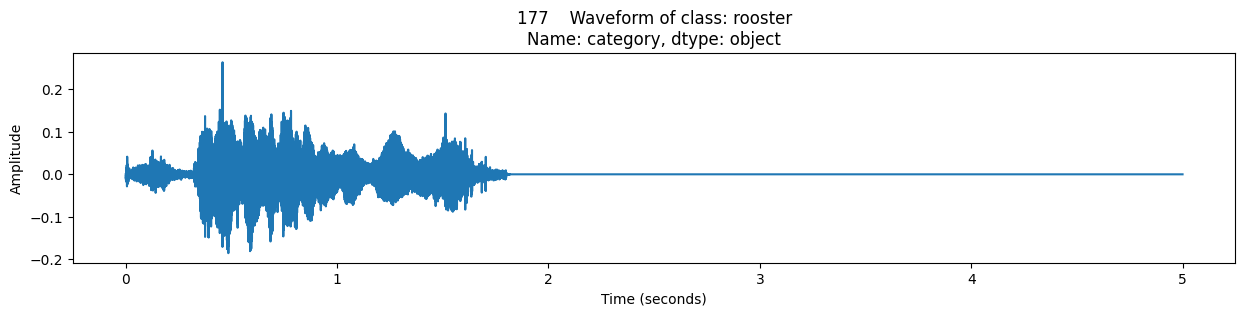

In [172]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 6))
Time = np.linspace(0, len(random_audio) / sr, num=len(random_audio))

# Waveform plot
plt.subplot(2, 1, 1)
plt.title('Waveform of class')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.title("Waveform of class: " + random_row["category"])
plt.plot(Time, random_audio)

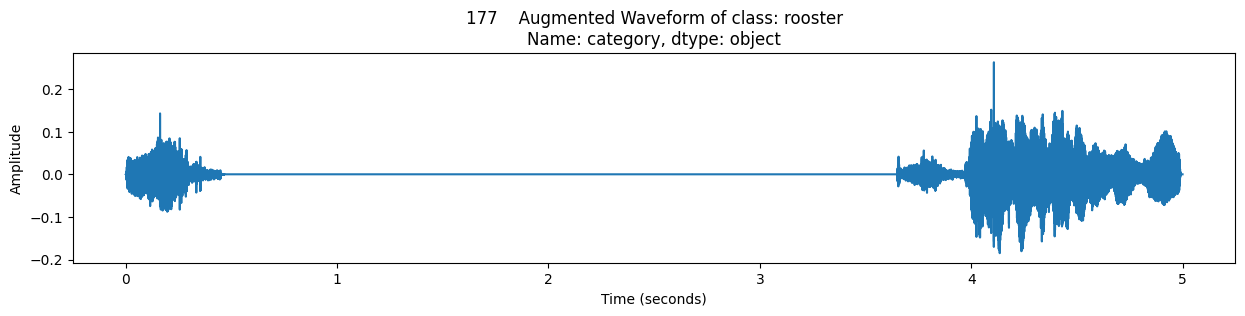

In [173]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 6))
Time = np.linspace(0, len(augmented_audio) / sr, num=len(augmented_audio))

# Waveform plot
plt.subplot(2, 1, 1)
plt.title('Waveform of class')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.title("Augmented Waveform of class: " + random_row["category"])
plt.plot(Time, augmented_audio)